In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [11]:
data = pd.read_csv("s2.csv")

data.head()

,Source,Chr,Position,Ref,Alt,Group,Type,Strand,Splice site,Distance,...,GENSCAN_ref,GENSCAN_alt,NetGene2_ref,NetGene2_alt,SplicePredictor_ref,SplicePredictor_alt,phyloP46way_placental,phyloP46way_primate,CADD_raw,CADD_phred
0,1000G,1,889159,A,C,Negative,Intronic,-,5',3,...,0.00,0.000,0.0,0.0,0.0,0.000,-0.31,-0.37,0.52,6.80
1,1000G,1,982941,T,C,Negative,Intronic,+,3',-12,...,0.97,0.966,0.0,0.0,0.9,0.859,-0.30,-1.53,-1.29,0.04
2,1000G,1,1891477,A,G,Negative,Intronic,-,3',-8,...,0.00,0.000,0.0,0.0,0.0,0.000,-0.46,0.45,1.11,9.52
3,1000G,1,2528133,T,C,Negative,Intronic,-,3',-5,...,0.00,0.000,0.0,0.0,0.0,0.000,-2.62,-4.05,-1.02,0.23
4,1000G,1,2541269,A,G,Negative,Exonic,-,3',2,...,0.00,0.000,0.0,0.0,0.0,0.000,-0.96,-0.23,1.31,10.28


In [12]:
features_columns = ["PWM_ref", "MES_ref", "NNSplice_ref", "HSF_ref", ]
label_column = ["Group"]

mask = False
for column in features_columns:
    mask = mask | (data[column] == 0)

filtered_data = data[~mask]
filtered_data.shape

(2857, 30)

In [13]:
def split(data, train_test_ration):
    split_index = int(len(data) * train_test_ration)
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data


def report_group_count_percent(data, data_type, group_column="Group"):
    positive_count = data[data[group_column] == "Positive"].shape[0]
    negative_count = data[data[group_column] == "Negative"].shape[0]

    positive_percent = (positive_count / len(data)) * 100
    negative_percent = (negative_count / len(data)) * 100

    print(
        f"{data_type} positive count: {positive_count}, negative count: {negative_count}"
    )
    print(
        f"{data_type} positive percent: {positive_percent:.2f}%, negative percent: {negative_percent:.2f}%"
    )

TRAIN_RATIO = 0.9

In [14]:
train_data, test_data = split(filtered_data, TRAIN_RATIO)

assert len(train_data) + len(test_data) == len(filtered_data)

report_group_count_percent(train_data, "train")
report_group_count_percent(test_data, "test")

train positive count: 925, negative count: 1646
train positive percent: 35.98%, negative percent: 64.02%
test positive count: 219, negative count: 67
test positive percent: 76.57%, negative percent: 23.43%


In [15]:
s_filtered_data = filtered_data.sample(frac=1)
s_train_data, s_test_data = split(s_filtered_data, TRAIN_RATIO)

assert len(s_train_data) + len(s_test_data) == len(s_filtered_data)

report_group_count_percent(s_train_data, "shuffled train")
report_group_count_percent(s_test_data, "shuffled test")

shuffled train positive count: 1034, negative count: 1537
shuffled train positive percent: 40.22%, negative percent: 59.78%
shuffled test positive count: 110, negative count: 176
shuffled test positive percent: 38.46%, negative percent: 61.54%


In [16]:
def plot_confusion_matrix_table(arr, title):
    fig, axes = plt.subplots(figsize=(4, 4))
    
    axes.imshow(arr, cmap=plt.cm.Blues)
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            axes.text(j, i, arr[i, j], ha="center", va="center", size=15)

    axes.set_title(title)
    axes.set_xlabel("Predicted")
    axes.set_ylabel("Actual")
    fig.tight_layout()


def plot_confusion_matrix(data, title):
    masks = [
        (data["Predicted"] == "Positive") & (data["Group"] == "Positive"),
        (data["Predicted"] == "Positive") & (data["Group"] == "Negative"),
        (data["Predicted"] == "Negative") & (data["Group"] == "Negative"),
        (data["Predicted"] == "Negative") & (data["Group"] == "Positive"),
    ]
    tp = data[masks[0]].shape[0]
    fp = data[masks[1]].shape[0]
    tn = data[masks[2]].shape[0]
    fn = data[masks[3]].shape[0]

    arr = np.array([[tp, fp], [fn, tn]])
    plot_confusion_matrix_table(arr, title)
    
def report_rates_and_confusion_matrix(data, title):
    tpr = data[data["Predicted"] == "Positive"].shape[0] / data.shape[0]
    fpr = data[data["Predicted"] == "Negative"].shape[0] / data.shape[0]
    print(f"{title} TPR: {tpr}, FPR: {fpr}")
    plot_confusion_matrix(data, title)

In [17]:
filtered_data.loc[:, "PWM_ratio"] = (
    filtered_data.loc[:, "PWM_ref"] / filtered_data.loc[:, "PWM_alt"]
)
filtered_data.loc[:, "PWM_ratio"]

C:\Users\gilgo\AppData\Local\Temp\ipykernel_5264\2051773254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, "PWM_ratio"] = (


0       0.934789
1       1.046187
2       1.024060
3       1.000000
5       1.003961
          ...   
2954    1.154094
2955    1.167520
2956    1.172326
2957    1.076665
2958         inf
Name: PWM_ratio, Length: 2857, dtype: float64

Train Confusion Matrix TPR: 0.5624270711785297, FPR: 0.43757292882147025
Test Confusion Matrix TPR: 0.7972027972027972, FPR: 0.20279720279720279


C:\Users\gilgo\AppData\Local\Temp\ipykernel_5264\2548711704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, "Predicted"] = filtered_data.loc[:, "PWM_ratio"].apply(classifier)


Shuffled Train Confusion Matrix TPR: 0.5853753403345002, FPR: 0.41462465966549983
Shuffled Test Confusion Matrix TPR: 0.5909090909090909, FPR: 0.4090909090909091


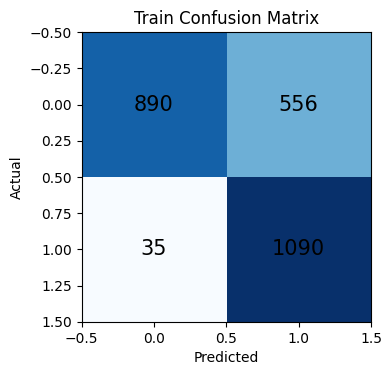

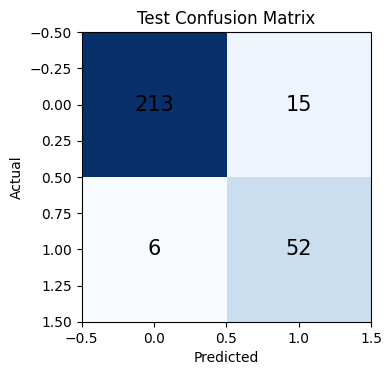

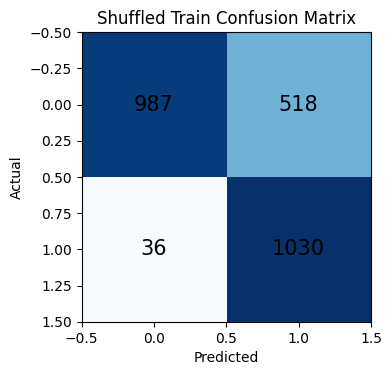

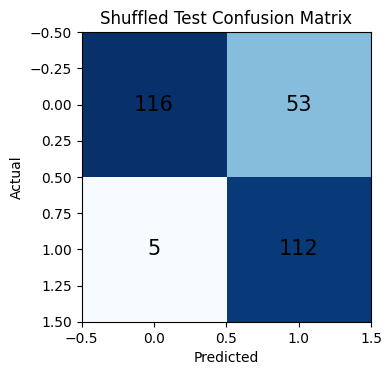

In [18]:
def classifier(PWM_ratio):
    return "Positive" if PWM_ratio > 1 else "Negative"


filtered_data.loc[:, "Predicted"] = filtered_data.loc[:, "PWM_ratio"].apply(classifier)

train_data, test_data = split(filtered_data, TRAIN_RATIO)

s_filtered_data = filtered_data.sample(frac=1)
s_train_data, s_test_data = split(s_filtered_data, TRAIN_RATIO)

report_rates_and_confusion_matrix(train_data, "Train Confusion Matrix")
report_rates_and_confusion_matrix(test_data, "Test Confusion Matrix")
report_rates_and_confusion_matrix(s_train_data, "Shuffled Train Confusion Matrix")
report_rates_and_confusion_matrix(s_test_data, "Shuffled Test Confusion Matrix")